In [1]:
import os
import sys
sys.path.append('/Users/wangqiqian/Desktop/TrafficTDApython/')

current_dir_path = os.getcwd()
current_file_path = os.path.abspath(current_dir_path)
current_dir_path = os.path.dirname(current_file_path)
parent_dir_path = os.path.dirname(current_dir_path)

# os.chdir(current_dir_path + '\\ultils')
os.chdir(current_dir_path + '/ultils')
print(current_dir_path)

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import AgglomerativeClustering

from functions import *
from chi import *
from regressionP import *
from models import *
from utils_v3 import *

os.chdir('/Users/wangqiqian/Desktop/TrafficTDApython/')
# os.chdir('C:/Users/USER/Desktop/TrafficTDApython/')

from Version3.tdamapper.core import MapperAlgorithm
from Version3.tdamapper.cover import CubicalCover
from Version3.tdamapper.clustering import FailSafeClustering
from Version3.tdamapper.plot import MapperLayoutInteractive

/Users/wangqiqian/Desktop/TrafficTDApython


In [2]:
data1 = pd.read_csv("Data/NPA_TMA2_1.csv", low_memory=False)[:-2]
data2 = pd.read_csv("Data/NPA_TMA2_2.csv", low_memory=False)[:-2]
data3 = pd.read_csv("Data/NPA_TMA2_3.csv", low_memory=False)[:-2]
data4 = pd.read_csv("Data/NPA_TMA2_4_new.csv", low_memory=False)[:-2]
data5 = pd.read_csv("Data/NPA_TMA2_5.csv", low_memory=False)[:-2]
data6 = pd.read_csv("Data/NPA_TMA2_6_new.csv", low_memory=False)[:-2]
data7 = pd.read_csv("Data/NPA_TMA2_7.csv", low_memory=False)[:-2]
data8 = pd.read_csv("Data/NPA_TMA2_8.csv", low_memory=False)[:-2]
data9 = pd.read_csv("Data/NPA_TMA2_9.csv", low_memory=False)[:-2]
data10 = pd.read_csv("Data/NPA_TMA2_10.csv", low_memory=False)[:-2]

dataA2 = pd.concat([data1, data2, data3, data4, data5, data6, data7, data8, data9, data10], ignore_index=True)
# dataA2 = pd.concat([data1, data2, data3, data4, data5], ignore_index=True)

dataA1 = pd.read_csv("Data/NPA_TMA1_V3.csv")[:-2]

In [3]:
dataA1.columns

Index(['發生年度', '發生月份', '發生日期', '發生時間', '事故類別名稱', '處理單位名稱警局層', '發生地點', '天候名稱',
       '光線名稱', '道路類別-第1當事者-名稱', '速限-第1當事者', '道路型態大類別名稱', '道路型態子類別名稱',
       '事故位置大類別名稱', '事故位置子類別名稱', '路面狀況-路面鋪裝名稱', '路面狀況-路面狀態名稱', '路面狀況-路面缺陷名稱',
       '道路障礙-障礙物名稱', '道路障礙-視距品質名稱', '道路障礙-視距名稱', '號誌-號誌種類名稱', '號誌-號誌動作名稱',
       '車道劃分設施-分向設施大類別名稱', '車道劃分設施-分向設施子類別名稱', '車道劃分設施-分道設施-快車道或一般車道間名稱',
       '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱', '事故類型及型態大類別名稱',
       '事故類型及型態子類別名稱', '肇因研判大類別名稱-主要', '肇因研判子類別名稱-主要', '死亡受傷人數', '當事者順位',
       '當事者區分-類別-大類別名稱-車種', '當事者區分-類別-子類別名稱-車種', '當事者屬-性-別名稱', '當事者事故發生時年齡',
       '保護裝備名稱', '行動電話或電腦或其他相類功能裝置名稱', '當事者行動狀態大類別名稱', '當事者行動狀態子類別名稱',
       '車輛撞擊部位大類別名稱-最初', '車輛撞擊部位子類別名稱-最初', '車輛撞擊部位大類別名稱-其他', '車輛撞擊部位子類別名稱-其他',
       '肇因研判大類別名稱-個別', '肇因研判子類別名稱-個別', '肇事逃逸類別名稱-是否肇逃', '經度', '緯度'],
      dtype='object')

In [4]:
select_lst = [
    '天候名稱', '光線名稱', 
    '道路類別-第1當事者-名稱', '速限-第1當事者', 
    # 保留大類別可能是冗長的
    '道路型態子類別名稱', '事故位置子類別名稱',
    '路面狀況-路面鋪裝名稱', '路面狀況-路面狀態名稱', '路面狀況-路面缺陷名稱',
    '道路障礙-障礙物名稱', '道路障礙-視距品質名稱', '道路障礙-視距名稱',
    '號誌-號誌種類名稱', '號誌-號誌動作名稱',
    '車道劃分設施-分向設施子類別名稱', '車道劃分設施-分道設施-快車道或一般車道間名稱', '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱',
    '事故類型及型態子類別名稱', '肇因研判子類別名稱-主要', '當事者區分-類別-子類別名稱-車種', '當事者屬-性-別名稱', '當事者事故發生時年齡',
    '保護裝備名稱', '行動電話或電腦或其他相類功能裝置名稱', '當事者行動狀態子類別名稱',
    '車輛撞擊部位子類別名稱-最初', '車輛撞擊部位子類別名稱-其他', '肇因研判子類別名稱-個別', '肇事逃逸類別名稱-是否肇逃',
    '死亡受傷人數'
]

def preprocess(input_data, select_lst):
    # 篩選到第一個順位，因為注重的是單次事故的情況
    sample_data = input_data[input_data['當事者順位'] == 1].reset_index(drop=True, inplace=False)
    sample_data = sample_data[sample_data['發生月份'] < 11]
    dataA = sample_data[select_lst]
    
    # 將資料分出死亡和受傷，合併到原本的資料後去除多餘的死亡受傷人數
    death_injury_data = split_death_injury(dataA['死亡受傷人數'])
    dist_df = pd.concat([dataA, death_injury_data], axis=1)
    # 補齊缺失值
    dist_df[select_lst] = dist_df[select_lst].fillna('未紀錄')

    dist_df.drop(columns=['死亡受傷人數'], inplace=True)
    
    return dist_df

dist_dfA1 = preprocess(dataA1, select_lst)
dist_dfA2 = preprocess(dataA2, select_lst)
# Concat
rbind_data = pd.concat([dist_dfA1, dist_dfA2], axis=0, ignore_index=True)

dummy_data: (312760, 332)


In [ ]:
bins_age = [0, 14, 24, 34, 44, 54, 64, 74, float('inf')]
labels_age = ['未滿15歲', '15~24', '25~34', '35~44', '45~54', '55~64', '65~74', '75+']

rbind_data['當事者事故發生時年齡'] = pd.cut(rbind_data['當事者事故發生時年齡'], bins=bins_age, labels=labels_age, right=False)

rbind_data['當事者事故發生時年齡'] = rbind_data['當事者事故發生時年齡'].cat.add_categories('未知')
rbind_data['當事者事故發生時年齡'] = rbind_data['當事者事故發生時年齡'].fillna('未知')

bins_speed = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, float('inf')]
labels_speed = ['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100', '101-110', '110+']

rbind_data['速限-第1當事者'] = pd.cut(rbind_data['速限-第1當事者'], bins=bins_speed, labels=labels_speed, right=False)

In [ ]:
# Sample
# rbind_data = rbind_data.sample(frac=0.3, random_state=43)
# sample_data_to_map.reset_index(drop=True, inplace=True)

# assert rbind_data.shape[0] == dist_dfA1.shape[0] + dist_dfA2.shape[0]
# Dummy
rbind_data["速限-第1當事者"] = rbind_data["速限-第1當事者"].astype(str)
dummy_data = pd.get_dummies(rbind_data)

print('dummy_data:', dummy_data.shape)

data_to_map = dummy_data.drop(['死亡', '受傷'], axis=1)
mapper_numpy = data_to_map.to_numpy()

In [5]:
with open('/Users/wangqiqian/Desktop/TrafficTDApython/Version3/GridSearch/full_grid_fulldata_o345i10.pkl', 'rb') as f:
    detailed_results_df = pickle.load(f)

detailed_results_df = detailed_results_df.sort_values(by='silhouette')
detailed_results_df

,overlap,interval,silhouette,mapper_info
2,5,10,0.230612,"((0, 28, 2, 50, 107, 125, 4, 6, 135, 24, 8, 30..."
0,3,10,0.263575,"((0, 28, 475, 755, 879, 2, 66, 176, 297, 546, ..."
1,4,10,0.291076,"((0, 26, 34, 450, 637, 2, 54, 172, 218, 4, 94,..."


In [5]:
# matrix = detailed_results_df.pivot_table(index="overlap", columns="interval", values="silhouette")
# # matrix[matrix < 0] = 0

# plt.figure(figsize=(8, 6))
# plt.imshow(matrix, cmap='Reds', aspect='auto', interpolation='nearest')
# plt.colorbar(label='Silhouette Coefficient')
# plt.xticks(range(len(matrix.columns)), matrix.columns, rotation=45)
# plt.yticks(range(len(matrix.index)), matrix.index)
# plt.xlabel('Interval')
# plt.ylabel('Overlap')
# plt.title('Heatmap of Silhouette Coefficients (Negative values set to 0)')
# plt.tight_layout()
# plt.show()

### Note
需要先做標籤再帶入，而不是帶入後標籤，原因在於如果cover內的資料沒有完整屬性，永遠不會標到最後的類別

In [6]:
choose = '速限-第1當事者'
rbind_data['color_for_plot'] = pd.factorize(rbind_data[choose])[0]
colors = rbind_data[choose].to_numpy()

mapper_plot1 = MapperLayoutInteractive(
    detailed_results_df['mapper_info'].iloc[2][0],
    # mapper_info[0],
    colors = colors,
    # colors=data_to_map['事故位置大類別名稱_路段'].to_numpy(),
    cmap = 'jet',
    agg = average_encoded_label,
    # agg = most_common_encoded_label,
    dim = 3,
    iterations = 50,
    seed = 10,
    width = 800,
    height = 800)

# fig_mean1 = mapper_plot1.plot()
# fig_mean1.show(config={'scrollZoom': True})

## Get data info

In [1017]:
x = vars(mapper_plot1._MapperLayoutInteractive__fig)['_data_objs'][1]['x']
y = vars(mapper_plot1._MapperLayoutInteractive__fig)['_data_objs'][1]['y']
z = vars(mapper_plot1._MapperLayoutInteractive__fig)['_data_objs'][1]['z']

threeDimData = pd.DataFrame({'x': x, 'y': y, 'z': z})

import re
data_tuple = vars(mapper_plot1._MapperLayoutInteractive__fig)['_data_objs'][1]['text']

data = []
for item in data_tuple:
    color = float(re.search(r'color: ([\d.]+)', item).group(1))
    node = int(re.search(r'node: (\d+)', item).group(1))
    size = int(re.search(r'size: (\d+)', item).group(1))
    data.append({'color': color, 'node': node, 'size': size})
component_info = pd.DataFrame(data)

full_info = pd.concat([component_info, threeDimData], axis=1)

mp_content_origin = vars(mapper_plot1._MapperLayoutInteractive__graph)['_node']

mp_content = pd.DataFrame.from_dict(mp_content_origin, orient='index')
mp_content.reset_index(inplace=True)
mp_content.rename(columns={'index': 'node'}, inplace=True)

full_info = pd.merge(full_info, mp_content, on=['node', 'size'], how='inner')

In [1018]:
def classify_x_z(row):
    if row['z'] > 0.05:
        return 2
    elif row['x'] > 0.06:
        return 4
    elif row['z'] <= 0.05:
        if row['x'] < -0.03:
            return 3
        elif row['z'] > -0.02:
            return 5
        else:
            return 1
    else:
        return 1

df['new_color'] = df.apply(classify_x_z, axis=1) #這是用於自己標色的部分

In [1019]:
df = full_info[(full_info['size'] > 30)]

rotate_df = pd.DataFrame(rotate_z(full_info[['x', 'y', 'z']], 110),
                columns=['x', 'y', 'z'])
rotate_df = pd.DataFrame(rotate_x(rotate_df[['x', 'y', 'z']], 30),
                columns=['x', 'y', 'z'])

df[['x', 'y', 'z']] = rotate_df[['x', 'y', 'z']]

from matplotlib.cm import get_cmap

unique_values = rbind_data[[choose, 'color_for_plot']].drop_duplicates()
df = df.merge(unique_values, left_on='color', right_on='color_for_plot', how='left')
color_mapping = df.groupby(choose)['color_for_plot'].first().to_dict()
unique_categories = list(color_mapping.keys())
color_palette = get_cmap("tab20", len(unique_categories)) 

color_mapping_fixed = {category: color_palette(i) for i, category in enumerate(unique_categories)}
df['color_for_plot_fixed'] = df[choose].map(color_mapping_fixed)

/var/folders/w2/_g9w5yys0f171q4qqm469z1h0000gn/T/ipykernel_10972/2947605636.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/w2/_g9w5yys0f171q4qqm469z1h0000gn/T/ipykernel_10972/2947605636.py:13: UserWarning:

You are merging on int and float columns where the float values are not equal to their int representation.

/var/folders/w2/_g9w5yys0f171q4qqm469z1h0000gn/T/ipykernel_10972/2947605636.py:16: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



### Note
包含原始資料屬性的做圖必須使用most_common_encoded_label，原因在於平均數值無法標示回原始資料來做圖

ValueError: 'c' argument must be a color, a sequence of colors, or a sequence of numbers, not [nan, nan, nan, (0.6196078431372549, 0.8549019607843137, 0.8980392156862745, 1.0), nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, (0.6196078431372549, 0.8549019607843137, 0.8980392156862745, 1.0), nan, (0.6196078431372549, 0.8549019607843137, 0.8980392156862745, 1.0), nan, (0.6196078431372549, 0.8549019607843137, 0.8980392156862745, 1.0), nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0)]

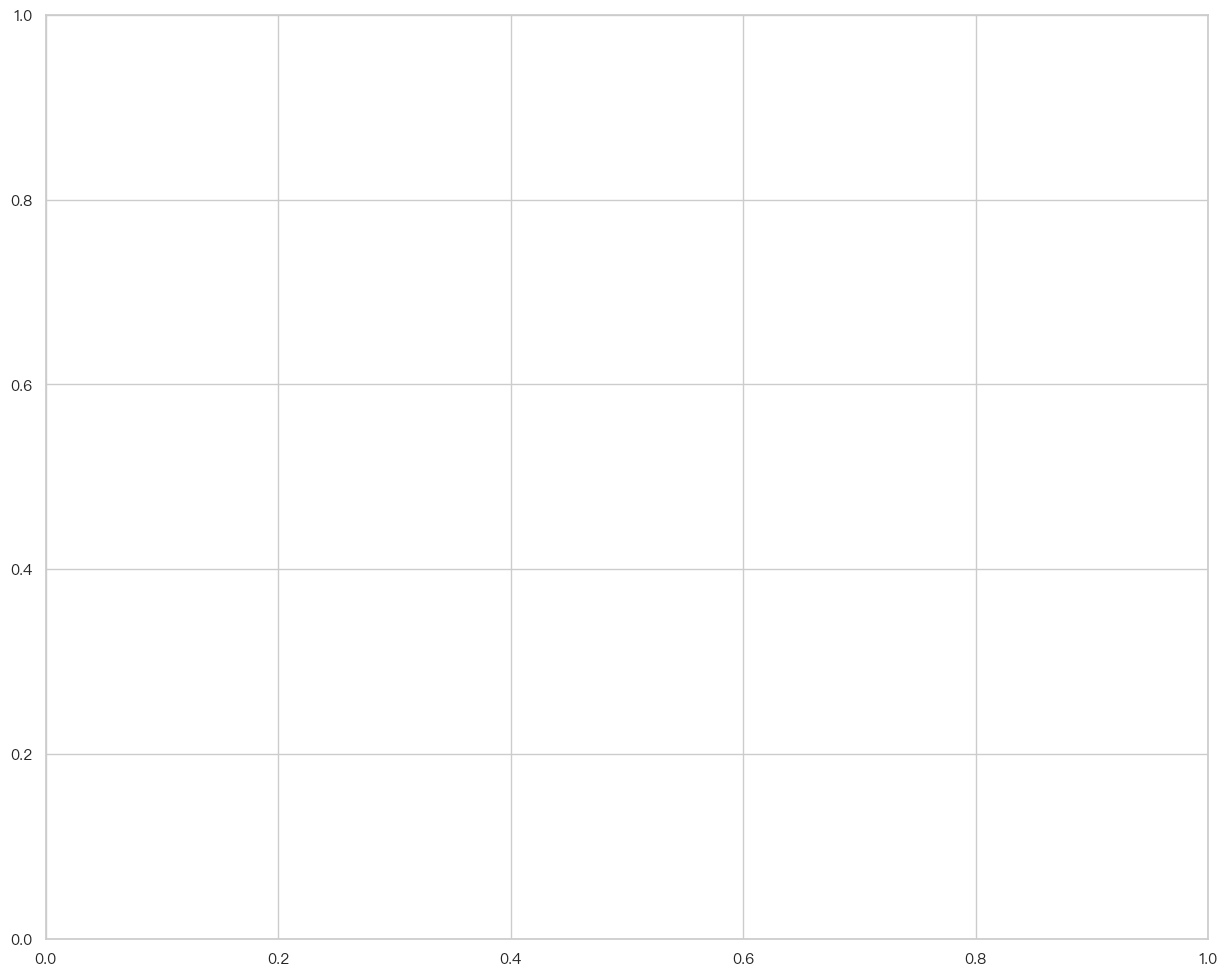

In [990]:
clipped_size = np.clip(df['size'], None, 500)

# 繪製節點
plt.figure(figsize=(15, 12))
scatter = plt.scatter(
    df['x'], df['z'],
    c=df['color_for_plot_fixed'].tolist(),
    s=clipped_size,
    marker='o',
    alpha=1
)

# 繪製邊
node_positions = {row['node']: (row['x'], row['z']) for _, row in df.iterrows()}
graph = vars(mapper_plot1._MapperLayoutInteractive__graph)
edges = graph['edges']
for edge in edges:
    if edge[0] in node_positions and edge[1] in node_positions:
        x_coords = [node_positions[edge[0]][0], node_positions[edge[1]][0]]
        y_coords = [node_positions[edge[0]][1], node_positions[edge[1]][1]]
        plt.plot(x_coords, y_coords, color='grey', alpha=0.5, linewidth=0.5, zorder=0)

# 添加圖例
handles = [
    plt.Line2D(
        [0], [0],
        marker='o',
        color=color_palette(i),
        markersize=10,
        label=name
    ) for i, name in enumerate(unique_categories)
]

plt.legend(handles=handles, title=f"{choose}", loc='upper right', bbox_to_anchor=(1.4, 1))
plt.xlabel('X')
plt.ylabel('Z')
plt.title('Mapper plot')
plt.grid(True)
plt.show()

In [ ]:
clipped_size = np.clip(df['size'], None, 500)

graph = vars(mapper_plot1._MapperLayoutInteractive__graph)
edges = graph['edges']

node_positions = {row['node']: (row['x'], row['z']) for _, row in df.iterrows()}

X = df['x'].values.reshape(-1, 1)
y = df['y'].values.reshape(-1, 1)

plt.figure(figsize=(15, 10))
scatter = plt.scatter(df['x'], df['z'], c=df['color'], cmap='viridis', s=clipped_size, marker='o', alpha=0.7)

for edge in edges:
    if edge[0] in node_positions and edge[1] in node_positions:
        x_coords = [node_positions[edge[0]][0], node_positions[edge[1]][0]]
        y_coords = [node_positions[edge[0]][1], node_positions[edge[1]][1]]
        plt.plot(x_coords, y_coords, color='grey', alpha=0.5, linewidth=0.5, zorder=0)

colorbar = plt.colorbar(scatter)
colorbar.set_label('Death rate')

plt.xlabel('X')
plt.ylabel('Z')
plt.title('Mapper plot')

plt.legend()
plt.grid(True)
plt.show()

![截圖 2024-12-01 晚上8.42.23.png](<attachment:截圖 2024-12-01 晚上8.42.23.png>)
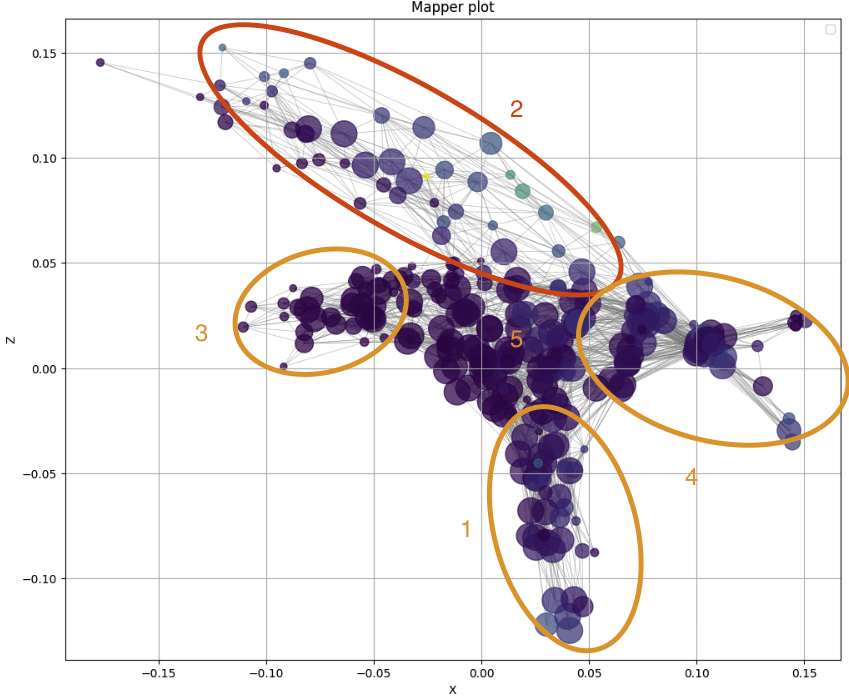

In [874]:
label_1 = df[df['new_color'] == 1]
label_2 = df[df['new_color'] == 2]
label_3 = df[df['new_color'] == 3]
label_4 = df[df['new_color'] == 4]
label_5 = df[df['new_color'] == 5]

count_1 = get_count_dict(label_1)
count_2 = get_count_dict(label_2)
count_3 = get_count_dict(label_3)
count_4 = get_count_dict(label_4)
count_5 = get_count_dict(label_5)

full_1 = rbind_data.loc[count_1.keys()]
full_2 = rbind_data.loc[count_2.keys()]
full_3 = rbind_data.loc[count_3.keys()]
full_4 = rbind_data.loc[count_4.keys()]
full_5 = rbind_data.loc[count_5.keys()]

In [610]:
tables = [full_1, full_2, full_3, full_4, full_5]
table_names = ["Group 1", "Group 2", "Group 3", "Group 4", "Group 5"]

# 創建空的結果資料
results = []

for table, name in zip(tables, table_names):
    death_counts = table['死亡'].value_counts().to_dict()  # 計算每個類別的數量
    death_counts['group'] = name  # 添加分組名稱
    results.append(death_counts)  # 添加到結果列表

# 將結果轉為資料表
death_summary = pd.DataFrame(results).fillna(0).set_index('group')
death_summary['> 0'] = death_summary.iloc[:, 1:].sum(axis=1)

death_summary_classified = death_summary[[0, '> 0']]
death_summary_classified

,0,> 0
group,,
Group 1,49026,189.0
Group 2,4255,84.0
Group 3,3244,2.0
Group 4,34123,386.0
Group 5,275973,943.0


In [611]:
death_summary_ratio = death_summary_classified.div(death_summary_classified.sum(axis=1), axis=0)

death_summary_ratio.round(4)

,0,> 0
group,,
Group 1,0.9962,0.0038
Group 2,0.9806,0.0194
Group 3,0.9994,0.0006
Group 4,0.9888,0.0112
Group 5,0.9966,0.0034


In [354]:
result = compare_categorical_features(full_4.drop(['死亡', '受傷'], axis=1), 
                                      full_5.drop(['死亡', '受傷'], axis=1))
result.sort_values(by="chi2", ascending=False)

,chi2,p_value
事故類型及型態子類別名稱,213815.006870,0.000000e+00
事故類型及型態大類別名稱,213171.768672,0.000000e+00
肇因研判子類別名稱-個別,80684.813637,0.000000e+00
道路型態子類別名稱,18094.404449,0.000000e+00
事故位置子類別名稱,15069.630271,0.000000e+00
道路型態大類別名稱,10057.106845,0.000000e+00
事故位置大類別名稱,9787.824771,0.000000e+00
道路類別-第1當事者-名稱,7291.088343,0.000000e+00
路面狀況-路面狀態名稱,6021.137648,0.000000e+00
路面狀況-路面缺陷名稱,5981.995935,0.000000e+00


In [453]:
result = compare_categorical_features(full_4.drop(['死亡', '受傷'], axis=1), 
                                      full_5.drop(['死亡', '受傷'], axis=1))
result.sort_values(by="chi2", ascending=False)

,chi2,p_value
事故類型及型態子類別名稱,213815.006870,0.000000e+00
事故類型及型態大類別名稱,213171.768672,0.000000e+00
肇因研判子類別名稱-個別,80684.813637,0.000000e+00
道路型態子類別名稱,18094.404449,0.000000e+00
事故位置子類別名稱,15069.630271,0.000000e+00
道路型態大類別名稱,10057.106845,0.000000e+00
事故位置大類別名稱,9787.824771,0.000000e+00
道路類別-第1當事者-名稱,7291.088343,0.000000e+00
路面狀況-路面狀態名稱,6021.137648,0.000000e+00
路面狀況-路面缺陷名稱,5981.995935,0.000000e+00


In [619]:
cat = "full_2"
cat2 = "full_4"
category_column = '事故類型及型態子類別名稱'

full_1_proportion = full_1[category_column].value_counts(normalize=True)
full_2_proportion = full_2[category_column].value_counts(normalize=True)
full_3_proportion = full_3[category_column].value_counts(normalize=True)
full_4_proportion = full_4[category_column].value_counts(normalize=True)
full_5_proportion = full_5[category_column].value_counts(normalize=True)

comparison_df = pd.DataFrame({
    'full_1': full_1_proportion,
    'full_2': full_2_proportion,
    'full_3': full_3_proportion,
    'full_4': full_4_proportion,
    'full_5': full_5_proportion
}).fillna(0)
comparison_df = comparison_df.sort_values(by='full_5', ascending=False)

comparison_df = comparison_df[comparison_df[cat] > 0.01]

In [620]:
full_2_proportion

事故類型及型態子類別名稱
追撞         0.640470
撞護欄(樁)     0.126757
同向擦撞       0.117308
其他         0.068910
路上翻車、摔倒    0.015902
側撞         0.008297
撞交通島       0.006453
對向擦撞       0.003227
衝出路外       0.002766
對撞         0.002535
撞號誌、標誌桿    0.001844
撞路樹        0.000922
撞橋樑(橋墩)    0.000691
撞動物        0.000691
撞電桿        0.000691
衝進路中       0.000461
撞非固定設施     0.000461
倒車撞        0.000461
撞建築物       0.000461
撞工程施工      0.000230
在路上作業中     0.000230
同向通行中      0.000230
Name: proportion, dtype: float64

In [ ]:
import seaborn as sns
from matplotlib.font_manager import FontProperties

myfont = FontProperties(fname=r"/System/Library/Fonts/PingFang.ttc")

# 設置Seaborn樣式
sns.set(style="whitegrid", font=myfont.get_name())

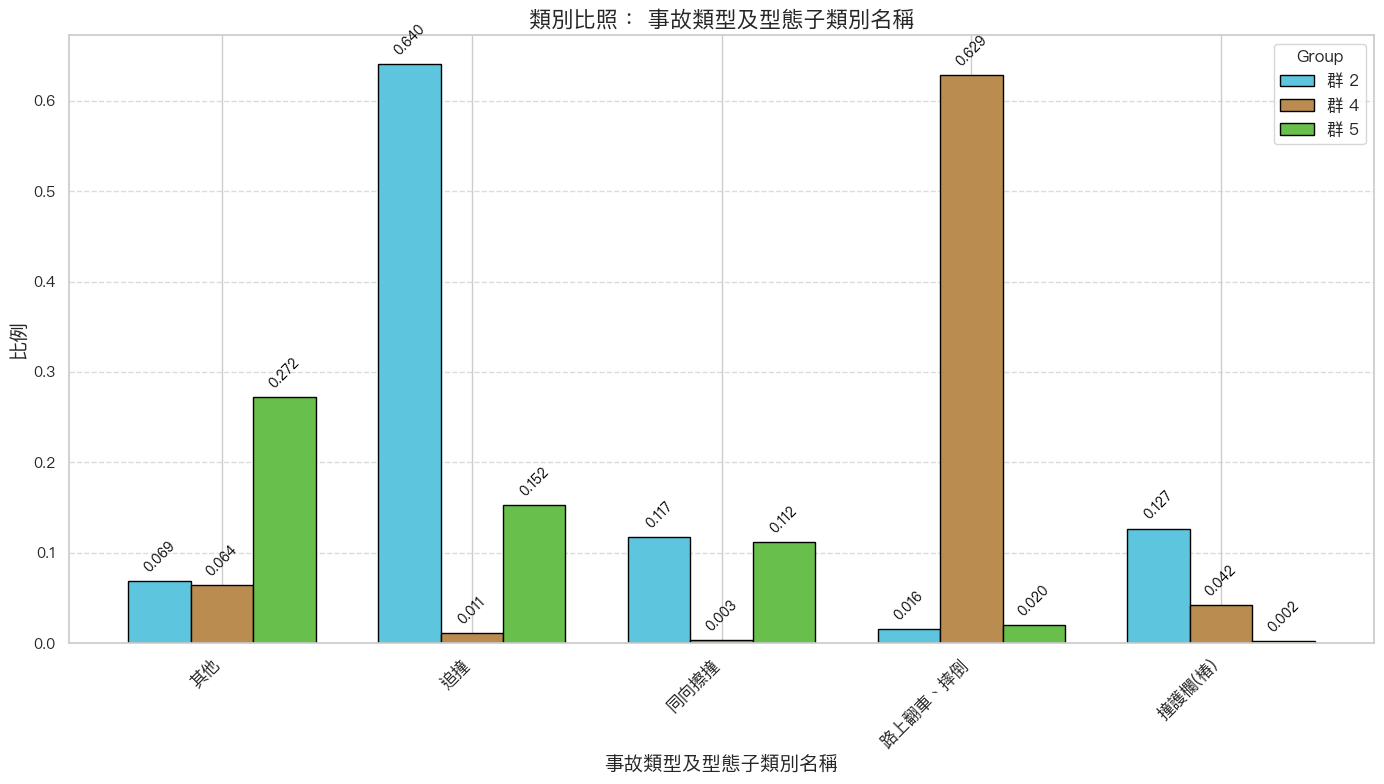

In [613]:
# 繪製條形圖
fig, ax = plt.subplots(figsize=(14, 8))
width = 0.25
x = range(len(comparison_df.index))

# 繪製條形圖
ax.bar(x, comparison_df[cat], width, label='群 2', color='#5dc6de', edgecolor='black')
ax.bar([i + width for i in x], comparison_df[cat2], width, label='群 4', color='#ba8c50', edgecolor='black')
ax.bar([i + 2 * width for i in x], comparison_df['full_5'], width, label='群 5', color='#68bf4b', edgecolor='black')

# 添加數據標籤
for i, val in enumerate(comparison_df[cat]):
    ax.text(i, val + 0.01, f"{val:.3f}", ha='center', fontsize=10, color='black', rotation=45)
for i, val in enumerate(comparison_df[cat2]):
    ax.text(i + width, val + 0.01, f"{val:.3f}", ha='center', fontsize=10, color='black', rotation=45)
for i, val in enumerate(comparison_df['full_5']):
    ax.text(i + 2 * width, val + 0.01, f"{val:.3f}", ha='center', fontsize=10, color='black', rotation=45)

# 設置標籤與標題
ax.set_title(f"類別比照： {category_column}", fontsize=16, fontweight='bold')
ax.set_ylabel("比例", fontsize=14)
ax.set_xlabel(category_column, fontsize=14)
ax.set_xticks([i + width for i in x])
# ax.set_xticks([i + width / 2 for i in x])
ax.set_xticklabels(comparison_df.index, rotation=45, ha='right', fontsize=12)
ax.legend(title="Group", fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# 調整圖表布局
plt.tight_layout()
plt.show()